# Installation, data loading, and imports

In [1]:
!pisces_setup

Converting Mads Olsen model to Keras...
Model saved at /Users/eric/Engineering/Work/pisces/pisces/cached_models/mo_resunet.keras


In [2]:
from nhrc_utils.analysis import *

LR_KERNEL_SIZE: 61


In [3]:
import numpy as np
from typing import List
import tensorflow as tf
import pisces.models as pm
from matplotlib import pyplot as plt
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
from typing import List

from tqdm import tqdm

import os
from pathlib import Path

CWD = Path(os.getcwd())
# NB! these are different from preprocess_data.ipynb
save_path = CWD.joinpath("fine_tuning")

hybrid_path = save_path.joinpath("hybrid")
os.makedirs(hybrid_path, exist_ok=True)
disordered_path = save_path.joinpath("disordered")
os.makedirs(disordered_path, exist_ok=True)
walch_path = save_path.joinpath("walch")
os.makedirs(walch_path, exist_ok=True)



# Training

## Create data tensors for training + evaluating

In [4]:
dataset = "walch"
walch_preprocessed_data = np.load('./pre_processed_data/walch/walch_preprocessed_data.npy',
                                   allow_pickle=True).item()
walch_keys = list(walch_preprocessed_data.keys())
walch_data_bundle = prepare_data(walch_preprocessed_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [5]:
walch_data_bundle.mo_predictions.shape

TensorShape([28, 1024, 4])

In [6]:
walch_data_bundle.spectrogram.shape

TensorShape([28, 15360, 32])

## Train LR CNN

In [7]:
import datetime
from tensorflow.keras.callbacks import TensorBoard

# Set up separate log directories for each model
log_dir_lr = f"./logs/lr_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
log_dir_cnn = f"./logs/cnn_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

# Configure TensorBoard callback
cnn_tensorboard_callback = TensorBoard(log_dir=log_dir_cnn, histogram_freq=1)
lr_tensorboard_callback = TensorBoard(log_dir=log_dir_lr, histogram_freq=1)

In [8]:

from analyses.NHRC.nhrc_utils.model_definitions import LR_CNN_NAME,  LABEL_SHAPE, LR_INPUT_SHAPE, WeightedModel, build_lr_cnn


split_maker = pm.LeaveOneOutSplitter()

training_results = []
lr_predictors = []

print(f"Training {LR_CNN_NAME} models...")
print("Saving models to", DEFAULT_EVALUATION_DIR)

# Split the data into training and testing sets
for k_train, k_test in tqdm(split_maker.split(walch_keys), desc="Next split", total=len(walch_keys)):
    # Convert indices to tensors
    train_idx_tensor = tf.constant(k_train, dtype=tf.int32)
    test_idx_tensor = tf.constant(k_test, dtype=tf.int32)

    # Gather the training and validation data using tf.gather
    # training
    train_data = tf.reshape(
        tf.gather(walch_data_bundle.activity, train_idx_tensor),
        LR_INPUT_SHAPE)
    train_labels = tf.reshape(
        tf.gather(walch_data_bundle.true_labels, train_idx_tensor),
        LABEL_SHAPE)
    train_sample_weights = tf.reshape(
        tf.gather(walch_data_bundle.sample_weights, train_idx_tensor),
        LABEL_SHAPE)

    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights, we can just set the labels to 0
    train_labels_masked = tf.where(train_sample_weights > 0, train_labels, 0.0)

    # z-normalize input data
    train_data = (train_data - tf.reduce_mean(train_data)) / np.std(train_data)


    # Custom loss function that includes the sample weights
    lr_cnn = build_lr_cnn()
    weighted_lr_cnn = WeightedModel(lr_cnn)
    weighted_lr_cnn.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    )

    dataset = tf.data.Dataset.from_tensor_slices(
        (train_data, train_labels_masked, train_sample_weights))
    dataset = dataset.batch(32)
    training_results.append(weighted_lr_cnn.fit(
        dataset,
        epochs=350, 
        verbose=0,
        callbacks=[lr_tensorboard_callback]
    ))


    lr_predictors.append(lr_cnn)
    lr_path = make_lr_filename(walch_keys[k_test[0]])
    lr_cnn.save(lr_path)

Training LR CNN models...
Saving models to /Users/eric/Engineering/Work/pisces/analyses/NHRC/evaluations


Next split: 100%|██████████| 28/28 [02:02<00:00,  4.38s/it]


In [9]:
import pandas as pd
from tqdm import tqdm

from analyses.NHRC.nhrc_utils.model_definitions import FINETUNING_INPUT_SHAPE, build_finetuning_model, EXTRA_LAYERS_NAME

split_maker = pm.LeaveOneOutSplitter()

training_results = []
evaluations = []
cnn_predictors = []

print(f"Training {EXTRA_LAYERS_NAME} models...")
print("Saving models to", DEFAULT_EVALUATION_DIR)

def finetuning_gather_reshape(data_bundle: PreparedData, train_idx_tensor: tf.Tensor, input_shape: tuple = FINETUNING_INPUT_SHAPE, output_shape: tuple = LABEL_SHAPE) -> tuple | None:
    train_data = tf.reshape(
        tf.gather(data_bundle.mo_predictions, train_idx_tensor),
        input_shape
        )
    train_labels = tf.reshape(
        tf.gather(data_bundle.true_labels, train_idx_tensor),
        output_shape)
    train_sample_weights = tf.reshape(
        tf.gather(data_bundle.sample_weights, train_idx_tensor),
        output_shape)
    return train_data, train_labels, train_sample_weights

# Split the data into training and testing sets
for k_train, k_test in tqdm(split_maker.split(walch_keys), desc="Next split", total=len(walch_keys)):
    # Convert indices to tensors
    train_idx_tensor = tf.constant(k_train, dtype=tf.int32)
    test_idx_tensor = tf.constant(k_test, dtype=tf.int32)

    # Gather the training and validation data using tf.gather
    # training
    train_data, train_labels, train_sample_weights = finetuning_gather_reshape(walch_data_bundle, train_idx_tensor)

    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights, we can just set the labels to 0
    train_labels_masked = tf.where(train_sample_weights > 0, train_labels, 0.0)

    # Train the model on the training set
    cnn = build_finetuning_model(FINETUNING_INPUT_SHAPE[1:])
    
    cnn.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4),
    )

    # gives weight 0 to -1 "mask" intervals, 1 to the rest


    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights,
    # we can just set the labels to 0
    train_labels_masked = np.where(train_sample_weights, train_labels, 0)

    training_results.append(cnn.fit(
        train_data, train_labels_masked, 
        epochs=100, 
        validation_split=0.0, 
        batch_size=1,
        sample_weight=train_sample_weights,
        verbose=0,
        callbacks=[cnn_tensorboard_callback]
    ))


    cnn_predictors.append(cnn)
    cnn_path = make_finetuning_filename(walch_keys[k_test[0]])
    cnn.save(cnn_path)
    # cnn.save(walch_path.joinpath(f"{k_test[0]}_cnn.h5"))




Training Fine Tuning models...
Saving models to /Users/eric/Engineering/Work/pisces/analyses/NHRC/evaluations


Next split: 100%|██████████| 28/28 [04:46<00:00, 10.25s/it]


## Hybrid data set

In [10]:
dataset = "hybrid"
hybrid_preprocessed_data = np.load(f'./pre_processed_data/{dataset}/{dataset}_preprocessed_data.npy',
                                   allow_pickle=True).item()

In [11]:
hybrid_keys = list(hybrid_preprocessed_data.keys())
hybrid_data_bundle = prepare_data(hybrid_preprocessed_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [12]:
# spike in Walch labels and weights from hybrid data bundle
hybrid_data_bundle.sample_weights = walch_data_bundle.sample_weights
hybrid_data_bundle.true_labels = walch_data_bundle.true_labels

# Log Reg

# Evaluation

In [13]:
from analyses.NHRC.nhrc_utils.model_definitions import MODEL_TYPES, cnn_pred_proba, lr_cnn_pred_proba, naive_pred_proba
from analyses.NHRC.nhrc_utils.analysis import SCENARIOS, EVALUATION_COLUMNS, DF_COLUMNS, auroc_balaccuracy_wasa


evaluations_df = pd.DataFrame([], columns=EVALUATION_COLUMNS)
scenarios = SCENARIOS
model_types = MODEL_TYPES 
evals = {s: 
    {m: [] for m in model_types} 
    for s in scenarios
}

for test_idx in range(len(hybrid_preprocessed_data)):
    stationary_weights = walch_data_bundle.sample_weights[test_idx].numpy()
    stationary_labels = walch_data_bundle.true_labels[test_idx].numpy()
    stationary_labels_masked = np.where(stationary_weights, stationary_labels, 0)
    stationary_wldm_predictions = walch_data_bundle.mo_predictions[test_idx].numpy()
    stationary_binary = naive_pred_proba(stationary_wldm_predictions)
    stationary_lr_input = walch_data_bundle.activity[test_idx].numpy()

    hybrid_weights = walch_data_bundle.sample_weights[test_idx].numpy()
    hybrid_labels = walch_data_bundle.true_labels[test_idx].numpy()
    hybrid_labels_masked = np.where(hybrid_weights, hybrid_labels, 0)
    hybrid_wldm_predictions = hybrid_data_bundle.mo_predictions[test_idx].numpy()
    hybrid_binary = naive_pred_proba(hybrid_wldm_predictions)
    hybrid_lr_input = hybrid_data_bundle.activity[test_idx].numpy()

    # z-normalize input data
    stationary_lr_input = (stationary_lr_input - np.mean(stationary_lr_input)) / np.std(stationary_lr_input)
    hybrid_lr_input = (hybrid_lr_input - np.mean(hybrid_lr_input)) / np.std(hybrid_lr_input)


    # Compute metrics for stationary 
    # Naive 1 - P(wake)
    naive_eval = auroc_balaccuracy_wasa(
        walch_keys[test_idx], 
        stationary_binary,
        stationary_weights,
        stationary_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[0]][model_types[0]] = naive_eval
    
    # Finetuning outputs of MO 
    finetuning_eval = auroc_balaccuracy_wasa(
        walch_keys[test_idx], 
        cnn_pred_proba(
            cnn_predictors[test_idx], 
            stationary_wldm_predictions),
        stationary_weights,
        stationary_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[0]][model_types[1]] = finetuning_eval
    
    # LR
    lr_eval = auroc_balaccuracy_wasa(
        walch_keys[test_idx], 
        lr_cnn_pred_proba(
            lr_predictors[test_idx], 
            stationary_lr_input),
        stationary_weights,
        stationary_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[0]][model_types[2]] = lr_eval

    # Compute metrics for hybrid
    # Naive
    naive_eval_hybrid = auroc_balaccuracy_wasa(
        hybrid_keys[test_idx], 
        hybrid_binary,
        hybrid_weights,
        hybrid_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[1]][model_types[0]] = naive_eval_hybrid
    
    #finetuning 
    finetuning_eval_hybrid = auroc_balaccuracy_wasa(
        hybrid_keys[test_idx], 
        cnn_pred_proba(
            cnn_predictors[test_idx], 
            hybrid_wldm_predictions),
        hybrid_weights,
        hybrid_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[1]][model_types[1]] = finetuning_eval_hybrid
    
    # LR
    lr_eval_hybrid = auroc_balaccuracy_wasa(
        hybrid_keys[test_idx], 
        lr_cnn_pred_proba(
            lr_predictors[test_idx], 
            hybrid_lr_input),
        hybrid_weights,
        hybrid_labels_masked,
        sleep_accuracy=WASA_SLEEP_ACCURACY)
    
    evals[scenarios[1]][model_types[2]] = lr_eval_hybrid
    
    # now append each evaluation to the dataframe, labeled correctly
    evaluations_df = pd.concat([evaluations_df,
                                pd.DataFrame([
            [walch_keys[test_idx],
             scenario,
             model,
             *evals[scenario][model][i],
             int(100 * WASA_SLEEP_ACCURACY[i])]
            for scenario in scenarios for model in model_types
            for i in range(len(WASA_SLEEP_ACCURACY))
        ], columns=DF_COLUMNS
    )])

Threshold: 0.7146216928958894, Accuracy: 0.9292604501607717
True sleep time: 622 minutes, predicted 656 minutes (%E: -0.03)
Threshold: 0.6473750174045564, Accuracy: 0.9485530546623794
True sleep time: 622 minutes, predicted 684 minutes (%E: -0.05)
Threshold: 0.5669672787189485, Accuracy: 0.9694533762057878
True sleep time: 622 minutes, predicted 723 minutes (%E: -0.08)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Threshold: 0.2849898189306258, Accuracy: 0.9308681672025724
True sleep time: 622 minutes, predicted 651 minutes (%E: -0.02)
Threshold: 0.1365603432059287, Accuracy: 0.9501607717041801
True sleep time: 622 minutes, predicted 671 minutes (%E: -0.04)
Threshold: 0.020418585278093926, Accuracy: 0.9694533762057878
True sleep time: 622 minutes, predicted 719 minutes (%E: -0.08)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Threshold: 0.339451178908348, Accuracy: 0.9308681672025724
True sleep time: 622 minutes, predicted 671 minutes (%E: -0.04)
Threshold: 0.28776024281978596, Accuracy: 0.95016077170

/var/folders/h4/pg7xmblx74zbp2yhls4bc_mh0000gn/T/ipykernel_78087/2807915903.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluations_df = pd.concat([evaluations_df,


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Threshold: 0.3392293006181718, Accuracy: 0.92904953145917
True sleep time: 747 minutes, predicted 741 minutes (%E: 0.00)
Threshold: 0.2630760222673417, Accuracy: 0.9491298527443106
True sleep time: 747 minutes, predicted 762 minutes (%E: -0.01)
Threshold: 0.1512305811047555, Accuracy: 0.9692101740294511
True sleep time: 747 minutes, predicted 786 minutes (%E: -0.03)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Threshold: 0.463192716240883, Accuracy: 0.92904953145917
True sleep time: 747 minutes, predicted 762 minutes (%E: -0.01)
Threshold: 0.42481596767902385, Accuracy: 0.9491298527443106
True sleep time: 747 minutes, predicted 781 minutes (%E: -0.02)
Threshold: 0.3682311922311784, Accuracy: 0.9692101740294511
True sleep time: 747 minutes, predicted 800 minutes (%E: -0.04)
Threshold: 0.747823864221573, Accuracy: 0.92904953145917
True sleep time: 747 minutes, predicted 761 minutes (%E: -0.01)
Threshold: 0.6809907257556916, Accuracy: 0.9491298527443106
True

In [14]:
evaluations_df.to_csv(DEFAULT_EVALUATION_DF_PATH, index=False)

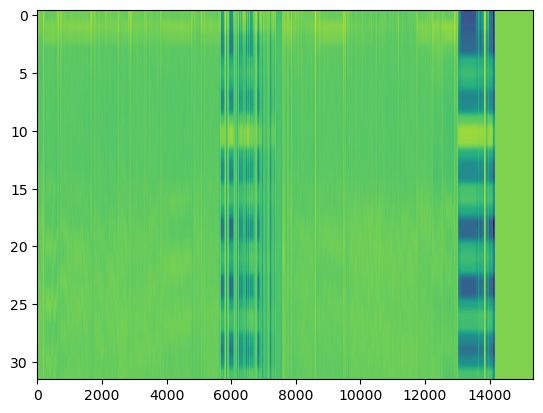

In [15]:
plt.imshow(walch_data_bundle.spectrogram[0].numpy().T, aspect='auto')